In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install --quiet scvi-colab
from scvi_colab import install
install()

/home/mo/miniconda3/envs/ivelo/lib/python3.8/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import torch
import os
import pickle
import mplscience
import scarches as sca
import matplotlib.pyplot as plt
import seaborn as sns
from velovi import VELOVI
# import ontology modules
from velovi.ontobj import *
from velovi._model import *


 captum (see https://github.com/pytorch/captum).
INFO:lightning_lite.utilities.seed:Global seed set to 0


In [4]:
#Choose dataset
dataset = "dentategyrus"

if dataset == "pbmc":
    cell_column = 'celltype'
elif dataset == "pancreas":
    cell_column = 'clusters'
elif dataset == "dentategyrus":
    cell_column = 'clusters'
elif dataset == "hindbrain":
    cell_column = 'Celltype'

#Choose model to train
model = "hivelo"

if model =="hivelo":
    use_ontology=True

In [5]:
if model =="hivelo":
    adata_file = "data/" + dataset + "/" + "processed_ontology.h5ad"
else:
    adata_file = "data/" + dataset + "/" + dataset + "_data_annotations.h5ad" #preprocessed data
adata_output = "data/" + dataset + "/" + model + "/" + "data_output.h5ad" #path so save output adata after training model
metrics_dict = "output/" + dataset + "/" + model + "/latent_analysis.pkl"

In [6]:
adata=sc.read(adata_file)

### Create ontology object

In [7]:
# initialize the Ontobj
# the description should be an identifier, e.g. the ontology used, here: PWO (Pathway Ontology)
pwo = Ontobj()

In [8]:
# initialize our ontology
# obo: path to an obo file
# gene_annot: path to a tab separated file with two columns: Genes and Ontology IDs
top_thresh=1000
bottom_thresh=30
path_ontology = "data/ontology/"
pwo.initialize_dag(obo=path_ontology + 'pw.obo',
                   gene_annot=path_ontology + 'gene_term_mapping.txt')

# trim the ontology
pwo.trim_dag(top_thresh=top_thresh, 
             bottom_thresh=bottom_thresh)

# create masks for decoder initialization
pwo.create_masks(top_thresh=top_thresh,
                 bottom_thresh=bottom_thresh)

# match a dataset to the ontology
# expr_path: path to the dataset (either h5ad)
pwo.match_dataset(expr_data = adata_file,
                  name=dataset)                                    

In [9]:
adata=pwo.data[str(top_thresh) + '_' + str(bottom_thresh)][dataset].copy()
vae=VELOVI.load("trained_models/" + dataset + "/" + model, adata)

INFO     File trained_models/dentategyrus/hivelo/model.pt already downloaded                                       
Last Decoder layer: identity


computing velocity graph (using 1/12 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


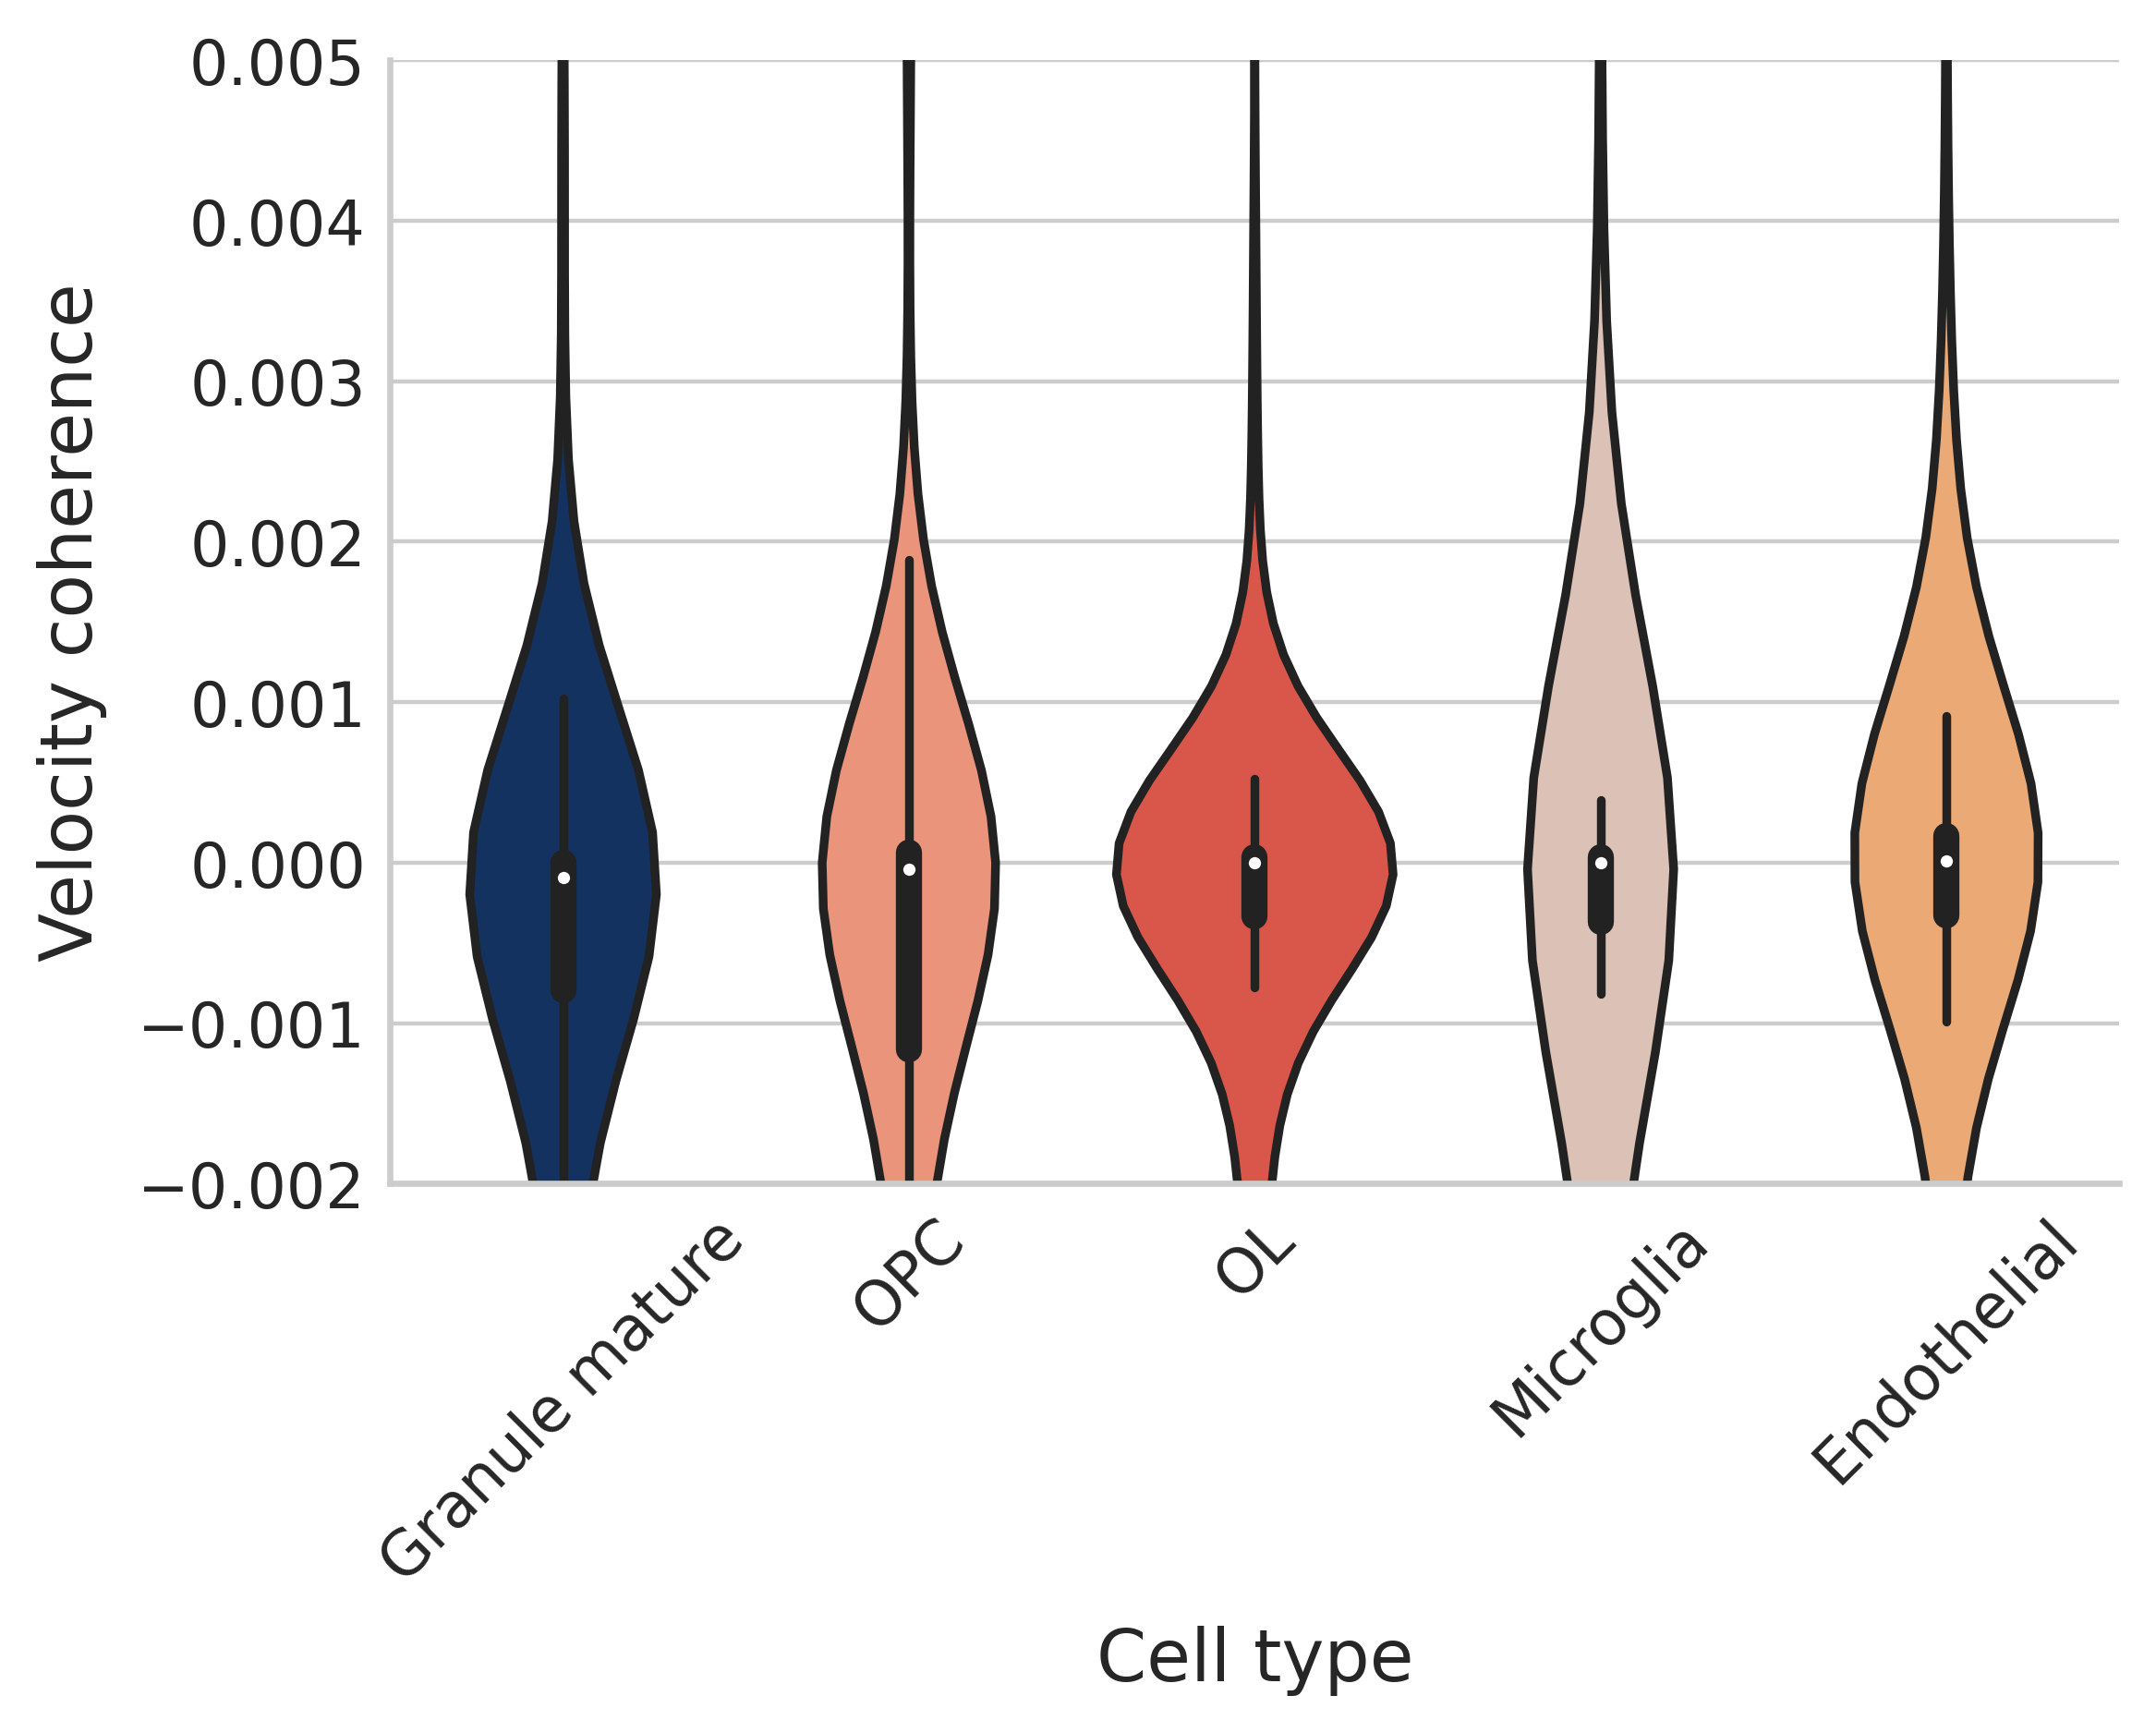

In [12]:
def compute_sign_variance(adata, vae):
    v_stack = vae.get_velocity(n_samples=50, velo_statistic="mean", return_mean=False)
    pos_freq = (v_stack >= 0).mean(0)
    # neg_freq = (v_stack < 0).mean(0)

    adata.layers["velocity"] = v_stack.mean(0)

    var_freq = pos_freq * (1 - pos_freq)
    adata.obs["sign_var"] = var_freq.mean(1)

    adata.layers["sign_var"] = var_freq
    adata.layers["variance"] = v_stack.var(0)

def compute_sign_var_score(adata, labels_key, vae):
    compute_sign_variance(adata, vae)

    sign_var_df = adata.to_df("sign_var")
    expr_df = adata.to_df("Ms")

    prod_df = sign_var_df * np.abs(expr_df)
    prod_df[labels_key] = adata.obs[labels_key]
    prod_df = prod_df.groupby(labels_key).mean()

    sign_var_df[labels_key] = adata.obs[labels_key]
    sign_var_df = sign_var_df.groupby(labels_key).mean()

    # max over clusters for a gene
    return sign_var_df.mean(0)

def gene_rank(adata, vkey="velocity"):
    from scipy.stats import rankdata
    scv.tl.velocity_graph(adata, vkey=vkey)
    tm = scv.utils.get_transition_matrix(
        adata, vkey=vkey, use_negative_cosines=True, self_transitions=True
    )
    tm.setdiag(0)
    adata.layers["Ms_extrap"] = tm @ adata.layers["Ms"]
    adata.layers["Ms_delta"] = adata.layers["Ms_extrap"] - adata.layers["Ms"]

    prod = adata.layers["Ms_delta"] * adata.layers[vkey]
    ranked = rankdata(prod, axis=1)
    adata.layers["product_score"] = prod
    adata.layers["ranked_score"] = ranked

sign_score = compute_sign_var_score(adata, 'clusters', vae)
gene_rank(adata)


cell_subset = adata.obs.query("clusters == 'Granule mature'").index
granule_mature_cluster_data = adata[cell_subset].copy()
granule_mature_cluster_data.var['mean_product_score_per_gene_granule_mature'] = granule_mature_cluster_data.layers['product_score'].mean(axis=0)
cell_subset = adata.obs.query("clusters == 'OPC'").index
opc_cluster_data = adata[cell_subset].copy()
opc_cluster_data.var['mean_product_score_per_gene_opc'] = opc_cluster_data.layers['product_score'].mean(axis=0)
cell_subset = adata.obs.query("clusters == 'OL'").index
ol_cluster_data = adata[cell_subset].copy()
ol_cluster_data.var['mean_product_score_per_gene_ol'] = ol_cluster_data.layers['product_score'].mean(axis=0)
cell_subset = adata.obs.query("clusters == 'Microglia'").index
microglia_cluster_data = adata[cell_subset].copy()
microglia_cluster_data.var['mean_product_score_per_gene_microglia'] = microglia_cluster_data.layers['product_score'].mean(axis=0)
cell_subset = adata.obs.query("clusters == 'Endothelial'").index
endothelial_cluster_data = adata[cell_subset].copy()
endothelial_cluster_data.var['mean_product_score_per_gene_endothelial'] = endothelial_cluster_data.layers['product_score'].mean(axis=0)


df = pd.concat(
    [
        pd.DataFrame(
            {
                'Velocity coherence': granule_mature_cluster_data.var['mean_product_score_per_gene_granule_mature'],
                'Cell type': 'Granule mature'
            }
        ),
        
        pd.DataFrame(
            {
                'Velocity coherence': opc_cluster_data.var['mean_product_score_per_gene_opc'],
                'Cell type': 'OPC'
            }
        ),
        pd.DataFrame(
            {
                'Velocity coherence': ol_cluster_data.var['mean_product_score_per_gene_ol'],
                'Cell type': 'OL'
            }
        ),
        pd.DataFrame(
            {
                'Velocity coherence': microglia_cluster_data.var['mean_product_score_per_gene_microglia'],
                'Cell type': 'Microglia'
            }
        ),
        pd.DataFrame(
            {
                'Velocity coherence': endothelial_cluster_data.var['mean_product_score_per_gene_endothelial'],
                'Cell type': 'Endothelial'
            }
        ),
    ],
    axis=0
)
palette = dict(zip(adata.obs['clusters'].cat.categories, adata.uns['clusters_colors']))

sns.set_style("whitegrid")
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.violinplot(data=df, x='Cell type', y='Velocity coherence', palette=palette)
    ax.set_ylim([-0.002, 0.005])
    ax.tick_params(axis='x', rotation=45)
    fig.savefig("figures/dentategyrus/"+ model + "/cellwise_coherence_" + model + ".png",
                transparent=True,
                bbox_inches='tight')